In [1]:
#Beating rate, 90% or 80% contraction amplitude, dp/dt, TTP, time to 90% relaxtion, tau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt,firwin
from scipy.integrate import simps
import os
from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from glob import glob

In [2]:
def moving_average(signal, window_size=4):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def preprocess_full_moving_avg(contraction_stress, frame_time_point, window_size=4, display=False):
    """
    Apply full moving average to the contraction stress signal.
    """
    frame_time_point_sec = frame_time_point / 100
    filtered = moving_average(contraction_stress, window_size=window_size)

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Full Moving Avg', color='blue')
        plt.title('Full Moving Average Smoothing', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered


def preprocess_selective_moving_avg(contraction_stress, frame_time_point, window_size=4, threshold_std=1.5, display=False):
    """
    Apply moving average only to regions without sharp transitions.
    """
    frame_time_point_sec = frame_time_point / 100
    derivative = np.abs(np.diff(contraction_stress, prepend=contraction_stress[0]))
    sharp_threshold = np.mean(derivative) + threshold_std * np.std(derivative)
    smooth_mask = derivative < sharp_threshold

    smoothed = moving_average(contraction_stress, window_size=window_size)
    filtered = contraction_stress.copy()
    filtered[smooth_mask] = smoothed[smooth_mask]

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Selective Moving Avg (no sharp zones)', color='orange')
        plt.title('Selective Moving Average (Avoids Sharp Transitions)', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered

def preprocess_moving_median(contraction_stress, frame_time_point, window_size=5, display=False):
    """
    Apply moving median filter to the contraction stress signal.
    
    Parameters:
        contraction_stress (array): Input signal.
        frame_time_point (array): Frame times (in 1/100 sec units).
        window_size (int): Window size for the median filter (should be odd).
        display (bool): Whether to plot the result.

    Returns:
        filtered (array): Median-filtered signal.
    """
    frame_time_point_sec = frame_time_point / 100
    filtered = median_filter(contraction_stress, size=window_size)

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Moving Median Filter', color='purple')
        plt.title('Moving Median Filter Smoothing', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered


In [3]:
def compute_signal_gradient(signal, time_vector, display=False, label='Signal'):
    """
    Compute the first derivative (gradient) of a signal over time.
    
    Parameters:
        signal (array): The signal to differentiate.
        time_vector (array): Time points corresponding to the signal.
        display (bool): If True, plot the signal and its gradient.
        label (str): Label for the signal in the plot (optional).
        
    Returns:
        gradient (array): The gradient of the signal.
    """
    gradient = np.gradient(signal, time_vector)

    if display:
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Plot original signal
        axs[0].plot(time_vector, signal, label=label, color='green')
        axs[0].set_ylabel('Signal Amplitude')
        axs[0].set_title('Original Signal')
        axs[0].legend()
        axs[0].grid(True)

        # Plot gradient
        axs[1].plot(time_vector, gradient, label='Gradient', color='purple')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('d(signal)/dt')
        axs[1].set_title('Signal Gradient (1st Derivative)')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    return gradient


In [4]:
def detect_contraction_rise_points(signal, time_vector, gradient_prominence=2, min_peak_distance=20, display=False):
    """
    Detect contraction rise points by finding gradient peaks (max slope)
    and the first preceding point where gradient changes from negative to positive.

    Parameters:
        signal (array): Filtered signal.
        time_vector (array): Corresponding time in seconds.
        gradient_prominence (float): Prominence threshold for gradient peaks.
        min_peak_distance (int): Minimum distance between peaks (in samples).
        display (bool): If True, plot the signal with detected points.

    Returns:
        zero_crossings (list): Indices where ∇ changes from negative to positive before rise peak.
    """
    gradient = np.gradient(signal, time_vector)

    # Step 1: Detect strong rising slopes (positive peaks in gradient)
    grad_peaks, _ = find_peaks(gradient, prominence=gradient_prominence, distance=min_peak_distance)

    # Step 2: For each peak, find first local min (∇ changes sign upward) before it
    zero_crossings = []
    for peak_idx in grad_peaks:
        for i in range(peak_idx - 1, 1, -1):
            if gradient[i - 1] < 0 and gradient[i] >= 0:
                zero_crossings.append(i)
                break

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(time_vector, signal, label='Filtered Signal', color='green')
        plt.plot(time_vector[zero_crossings], signal[zero_crossings], 'bo', label='Start Activation (∇ crosses up)')
        plt.title('Detected Contraction Rise Points')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return zero_crossings

In [5]:
def calculate_beating_rate(peak_indices, time_vector, display=True):
    """
    Calculate beating rate (BPM) and frequency (Hz) from peak indices.

    Parameters:
        peak_indices (array): Indices of detected peaks.
        time_vector (array): Time in seconds corresponding to signal samples.
        display (bool): If True, print BPM and frequency.

    Returns:
        bpm (float): Beating rate in beats per minute.
        freq_hz (float): Beating frequency in Hz.
        time_intervals (array): Time between beats (seconds).
    """
    if len(peak_indices) < 2:
        if display:
            print("Not enough peaks to calculate beating rate.")
        return None, None, []

    # Get time values at peaks
    peak_times = time_vector[peak_indices]

    # Calculate intervals and statistics
    time_intervals = np.diff(peak_times)
    avg_interval = np.mean(time_intervals)
    bpm = int(60 / avg_interval)
    freq_hz = 1 / avg_interval

    if display:
        print(f"Beating Rate: {bpm} BPM")
        print(f"Calculated Frequency: {freq_hz:.2f} Hz")

    return bpm, freq_hz, time_intervals


In [6]:
def compute_relative_contraction_amplitudes_to_baseline(signal, peaks, baseline_per_cycle,
                                                        threshold_percentage=0.9, display=True):
    """
    Compute contraction amplitudes from peak to baseline per cycle, and derive threshold-based amplitudes (e.g., 90%).

    Parameters:
        signal (array): The filtered contraction signal.
        peaks (array): Indices of contraction peaks, aligned to baseline_per_cycle.
        baseline_per_cycle (list or array): Baseline signal value per cycle.
        threshold_percentage (float): Fraction of peak-to-baseline amplitude (e.g., 0.9 = 90%).
        display (bool): If True, print amplitude per cycle and mean.

    Returns:
        full_amplitudes (list): Peak-to-baseline amplitudes.
        threshold_amplitudes (list): threshold_percentage amplitudes per cycle.
        mean_threshold_amp (float): Mean of threshold_percentage amplitudes.
    """
    peaks = np.array(peaks)
    baseline_per_cycle = np.array(baseline_per_cycle)

    assert len(peaks) == len(baseline_per_cycle), "Mismatch: peaks and baseline_per_cycle must be aligned"

    full_amplitudes = []
    threshold_amplitudes = []

    for i, (peak_idx, baseline_val) in enumerate(zip(peaks, baseline_per_cycle)):
        peak_val = signal[peak_idx]
        amp = peak_val - baseline_val
        full_amplitudes.append(amp)
        threshold_amplitudes.append(amp * threshold_percentage)

        if display:
            print(f"Cycle {i+1}: Amplitude = {amp:.3f}, {int(threshold_percentage*100)}% = {amp * threshold_percentage:.3f}")

    mean_threshold_amp = np.mean(threshold_amplitudes) if threshold_amplitudes else None

    if display:
        if mean_threshold_amp is not None:
            print(f"\nMean {int(threshold_percentage*100)}% contraction amplitude: {mean_threshold_amp:.3f}")
        else:
            print("No valid contraction cycles found.")

    return full_amplitudes, threshold_amplitudes, mean_threshold_amp


In [7]:
def compute_time_to_peak(time_vector, peaks, start_activation_idx, display=False):
    """
    Compute time-to-peak (TTP) from activation onset to the next peak for each contraction cycle.

    Ensures first activation comes before first peak, and last peak before last activation.

    Parameters:
        time_vector (array): Time values in seconds.
        peaks (array): Indices of contraction peaks.
        start_activation_idx (array): Indices where the signal starts to rise (activation).
        display (bool): If True, print TTP values.

    Returns:
        time_to_peaks (list): Time to peak per cycle (s).
        mean_ttp (float): Mean TTP across valid cycles.
    """
    peaks = np.array(peaks)
    start_activation_idx = np.array(start_activation_idx)

    # Align activation indices with peaks
    if start_activation_idx[0] > peaks[0]:
        peaks = peaks[1:]
    if peaks[-1] > start_activation_idx[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(start_activation_idx))
    peaks = peaks[:min_len]
    start_activation_idx = start_activation_idx[:min_len]

    time_to_peaks = []

    for i, (peak_idx, activation_idx) in enumerate(zip(peaks, start_activation_idx)):
        if activation_idx < peak_idx:
            ttp = time_vector[peak_idx] - time_vector[activation_idx]
            time_to_peaks.append(ttp)
            if display:
                print(f"Cycle {i+1}: Time to Peak = {ttp:.3f} s")
        elif display:
            print(f"Cycle {i+1}: Skipped (activation idx {activation_idx} not before peak idx {peak_idx})")

    mean_ttp = np.mean(time_to_peaks) if time_to_peaks else None

    if display:
        print(f"\nMean Time to Peak: {mean_ttp:.3f} s" if mean_ttp is not None else "No valid cycles found.")

    return time_to_peaks, mean_ttp


In [8]:
def detect_contraction_relaxation_end_points(signal, time_vector, gradient_prominence=2, min_peak_distance=20, display=False):
    """
    Detect true end of contraction relaxation: find local minima in the gradient where the
    derivative changes sign from negative to positive.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector in seconds.
        gradient_prominence (float): Prominence threshold for gradient troughs.
        min_peak_distance (int): Minimum spacing between detected minima.
        display (bool): If True, plot result.

    Returns:
        relax_end_points (list): Indices of points where gradient changes from negative to positive.
    """
    gradient = np.gradient(signal, time_vector)

    # Step 1: Find troughs (steepest downward slopes)
    grad_troughs, _ = find_peaks(-gradient, prominence=gradient_prominence, distance=min_peak_distance)

    relax_end_points = []

    # Step 2: For each trough, find where the gradient crosses zero upward (local min)
    for trough_idx in grad_troughs:
        for i in range(trough_idx + 1, len(gradient) - 1):
            if gradient[i] <= 0 and gradient[i + 1] > 0:
                relax_end_points.append(i)
                break

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(time_vector, signal, label='Filtered Signal', color='black')
        plt.plot(time_vector[relax_end_points], signal[relax_end_points], 'bo', label='End of Relaxation (∇ changes sign)')
        plt.title('True End of Relaxation Points (Local Minima in ∇)')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN/mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return relax_end_points


In [21]:
def align_contraction_cycles_with_next_activation(peaks, start_activations, end_relaxations):
    """
    Align contraction cycles to include:
    - current activation (start of cycle)
    - one peak
    - following relaxation
    - next activation (for computing baseline)

    Parameters:
        peaks (array): Indices of contraction peaks.
        start_activations (array): Indices where activation begins (∇ < 0).
        end_relaxations (array): Indices where relaxation ends (∇ ≥ 0).

    Returns:
        aligned_activations (list)
        aligned_peaks (list)
        aligned_relaxations (list)
        next_activations (list)
    """
    peaks = np.array(peaks)
    start_activations = np.array(start_activations)
    end_relaxations = np.array(end_relaxations)

    aligned_activations = []
    aligned_peaks = []
    aligned_relaxations = []
    next_activations = []

    for i in range(len(start_activations) - 1):
        act_start = start_activations[i]
        act_next = start_activations[i + 1]

        # Find peak between current and next activation
        peak_candidates = peaks[(peaks > act_start) & (peaks < act_next)]
        if len(peak_candidates) == 0:
            continue
        peak = peak_candidates[0]

        # Find relaxation after the peak but before next activation
        relax_candidates = end_relaxations[(end_relaxations > peak) & (end_relaxations < act_next)]
        if len(relax_candidates) == 0:
            continue
        relax = relax_candidates[0]

        # Save cycle components
        aligned_activations.append(act_start)
        aligned_peaks.append(peak)
        aligned_relaxations.append(relax)
        next_activations.append(act_next)

    return (
        np.array(aligned_activations),
        np.array(aligned_peaks),
        np.array(aligned_relaxations),
        np.array(next_activations)
    )


In [48]:
def compute_baseline_per_cycle(signal, time_vector,
                                aligned_rels, aligned_next_acts,
                                peaks=None, aligned_peaks=None,
                                plot=True):
    """
    Compute baseline between aligned relaxation and next activation indices.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time in seconds.
        aligned_rels (array): Relaxation indices per cycle (end-of-relaxation).
        aligned_next_acts (array): Activation start indices of next cycle.
        peaks (array): All peak indices (for context plotting).
        aligned_peaks (array): Peaks per aligned cycle (optional).
        plot (bool): Whether to plot signal with baselines and markers.

    Returns:
        baseline_per_cycle (list): Mean value from relax to next activation.
        baseline_pairs (list of tuples): (relax_idx, next_activation_idx)
    """
    baseline_per_cycle = []
    baseline_pairs = []

    for r, a in zip(aligned_rels, aligned_next_acts):
        if a > r:
            segment = signal[r:a + 1]
            mean_val = np.mean(segment)
            baseline_per_cycle.append(mean_val)
            baseline_pairs.append((r, a))

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(time_vector, signal, color='black', label='Filtered Signal')

        if peaks is not None:
            plt.plot(time_vector[peaks], signal[peaks], 'gray', linestyle=':', label='All Peaks')
        if aligned_peaks is not None:
            plt.plot(time_vector[aligned_peaks], signal[aligned_peaks], 'r^', label='Aligned Peaks')

        plt.plot(time_vector[aligned_rels], signal[aligned_rels], 'go', label='Relaxation Ends')
        plt.plot(time_vector[aligned_next_acts], signal[aligned_next_acts], 'bo', label='Next Activations')
        
        # Add legend label only once
        for idx, ((r, a), y) in enumerate(zip(baseline_pairs, baseline_per_cycle)):
            x1, x2 = time_vector[r], time_vector[a]
            label = 'Baseline ({} cycles)'.format(len(baseline_per_cycle)) if idx == 0 else None
            plt.hlines(y=y, xmin=x1, xmax=x2, colors='purple', linestyles='--', linewidth=2, label=label)

        plt.title('Baselines Between Relaxation → Next Activation')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN/mm²)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return baseline_per_cycle, baseline_pairs


In [11]:
def compute_peak_to_percent_relaxation_time(signal, time_vector, aligned_peaks, baseline_per_cycle,
                                            relax_percentage=0.9, display=False):
    """
    Compute the time from each peak to a percentage of relaxation toward the baseline (e.g., 90%).

    Parameters:
        signal (array): The filtered signal.
        time_vector (array): Time values in seconds.
        aligned_peaks (array): Indices of contraction peaks, aligned to cycles.
        baseline_per_cycle (list or array): Baseline (relaxed) values per cycle.
        relax_percentage (float): Percent of relaxation (e.g., 0.9 = 90% relaxation).
        display (bool): If True, print each result.

    Returns:
        t_relax_times (list): Time (in seconds) to reach desired relaxation per cycle.
        mean_t_relax (float): Mean relaxation time across valid cycles.
    """
    aligned_peaks = np.array(aligned_peaks)
    baseline_per_cycle = np.array(baseline_per_cycle)

    assert len(aligned_peaks) == len(baseline_per_cycle), "peaks and baselines must be aligned"

    t_relax_times = []

    for i, (peak_idx, baseline_val) in enumerate(zip(aligned_peaks, baseline_per_cycle)):
        peak_val = signal[peak_idx]
        relax_target = baseline_val + (peak_val - baseline_val) * (1 - relax_percentage)

        # Search forward from peak until signal <= relax_target
        for j in range(peak_idx, len(signal)):
            if signal[j] <= relax_target:
                t_relax = time_vector[j] - time_vector[peak_idx]
                t_relax_times.append(t_relax)
                if display:
                    print(f"Cycle {i+1}: T{int(relax_percentage * 100)}R = {t_relax:.3f} s (target = {relax_target:.3f})")
                break
        else:
            if display:
                print(f"Cycle {i+1}: Skipped (signal never reached {int(relax_percentage * 100)}% relaxation target)")

    mean_t_relax = np.mean(t_relax_times) if t_relax_times else None

    if display:
        if mean_t_relax is not None:
            print(f"\nMean Time to {int(relax_percentage * 100)}% Relaxation: {mean_t_relax:.3f} s")
        else:
            print("No valid cycles found.")

    return t_relax_times, mean_t_relax

In [12]:

def exp_decay(t, P0, tau, Pasym):
    return (P0 - Pasym) * np.exp(-t / tau) + Pasym

def compute_relaxation_time_constants_toactive(signal, time_vector, peaks, activation_idxs,
                                      gradient_full, baseline_per_cycle,
                                      display_graphs=False, display_print=False):
    """
    Compute exponential decay time constant (τ) for each contraction cycle,
    starting from the inflection point (after the peak) until the signal reaches the
    baseline (Pasym), bounded by the next activation point.

    Also saves the result plots as images in 'decay_fit_images/'.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector (same length as signal).
        peaks (array): Indices of contraction peaks.
        activation_idxs (array): Indices where the next contraction starts.
        gradient_full (array): First derivative (gradient) of the signal.
        baseline_per_cycle (list): List of per-cycle baseline (Pasym) values.
        display_graphs (bool): If True, show fit plots.
        display_print (bool): If True, print τ values per cycle.

    Returns:
        taus (list): Tau values per valid contraction.
        mean_tau (float): Mean τ value.
    """
    peaks = np.array(peaks)
    activation_idxs = np.array(activation_idxs)
    signal = np.array(signal)
    time_vector = np.array(time_vector)
    gradient_full = np.array(gradient_full)
    baseline_per_cycle = np.array(baseline_per_cycle)

    # Create output folder for plots
    output_dir = "decay_fit_images"
    os.makedirs(output_dir, exist_ok=True)

    if activation_idxs[0] < peaks[0]:
        activation_idxs = activation_idxs[1:]
    if peaks[-1] > activation_idxs[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(activation_idxs), len(baseline_per_cycle))
    peaks = peaks[:min_len]
    activation_idxs = activation_idxs[:min_len]
    baseline_per_cycle = baseline_per_cycle[:min_len]

    taus = []

    for i, (peak_idx, next_activation_idx) in enumerate(zip(peaks, activation_idxs)):
        if next_activation_idx <= peak_idx or next_activation_idx - peak_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (invalid peak→activation window)")
            continue

        grad_segment = gradient_full[peak_idx:next_activation_idx]
        inflection_rel_idx = np.argmin(grad_segment)
        inflection_idx = peak_idx + inflection_rel_idx

        if next_activation_idx - inflection_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (inflection too close to activation)")
            continue

        Pasym_fixed = baseline_per_cycle[i]
        P0_guess = signal[inflection_idx]
        tolerance = 0.005 * abs(P0_guess - Pasym_fixed)
        threshold = Pasym_fixed + tolerance

        signal_after_inflection = signal[inflection_idx:next_activation_idx]
        below_thresh_idxs = np.where(signal_after_inflection <= threshold)[0]

        if len(below_thresh_idxs) == 0:
            if display_print:
                print(f"Cycle {i+1}: Skipped (signal never reached baseline before activation)")
            continue

        fit_end_idx = inflection_idx + below_thresh_idxs[0]
        t_segment = time_vector[inflection_idx:fit_end_idx + 1]
        s_segment = signal[inflection_idx:fit_end_idx + 1]

        if len(t_segment) < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (segment too short)")
            continue

        def fit_func(t, P0, tau):
            return exp_decay(t, P0, tau, Pasym_fixed)

        p0 = [s_segment[0], (t_segment[-1] - t_segment[0]) / 2]

        try:
            popt, _ = curve_fit(fit_func, t_segment - t_segment[0], s_segment, p0=p0, maxfev=10000)
            _, tau_fit = popt
            taus.append(tau_fit)

            # Plot and save
            fit_curve = fit_func(t_segment - t_segment[0], *popt)
            plt.figure(figsize=(8, 4))
            plt.plot(t_segment, s_segment, 'b.', label='Data')
            plt.plot(t_segment, fit_curve, 'r--', label=f'Fit (τ = {tau_fit:.2f} s)')
            plt.axvline(x=time_vector[inflection_idx], color='g', linestyle=':', label='Inflection Point')
            plt.hlines(Pasym_fixed, t_segment[0], t_segment[-1], color='purple', linestyle='--', label='Baseline')
            plt.hlines(threshold, t_segment[0], t_segment[-1], color='orange', linestyle='--', label='Tolerance Threshold')
            plt.title(f'Exponential Decay Fit — Cycle {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Contraction Signal')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            # Save to file
            filename = os.path.join(output_dir, f"cycle_{i+1:02d}_fit.png")
            plt.savefig(filename)

            if display_graphs:
                plt.show()
            else:
                plt.close()

            if display_print:
                print(f"Cycle {i+1}: τ = {tau_fit:.3f} s")

        except RuntimeError:
            if display_print:
                print(f"Cycle {i+1}: Fit failed.")

    mean_tau = np.mean(taus) if taus else None
    if display_print:
        print(f"\nMean τ across cycles: {mean_tau:.3f} s" if mean_tau is not None else "No valid tau values.")

    return taus, mean_tau


In [39]:
def create_summary_excel_with_means(signal, time_vector, peaks, end_relax_idxs, start_activation_idx, output_filename="contraction_summary_with_means.xlsx"):
    
    bpm, freq_hz, _ = calculate_beating_rate(peaks, time_vector, display=False)
    
    baseline_per_cycle, baseline_pairs = compute_baseline_per_cycle(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    aligned_rels=aligned_rels,
    aligned_next_acts=aligned_next_acts,
    peaks=peaks,
    aligned_peaks=aligned_peaks,
    plot=True
)

    amps, amps_90, mean_amp_90 = compute_relative_contraction_amplitudes_to_baseline(
    signal, aligned_peaks, baseline_per_cycle, threshold_percentage=0.9, display=False)
    
    ttp, mean_ttp = compute_time_to_peak(time_vector, aligned_peaks, start_activation_idx)
    
    t90r, mean_t90r = compute_peak_to_percent_relaxation_time(
    signal, time_vector, aligned_peaks, baseline_per_cycle, relax_percentage=0.9, display=False)
    
    taus, mean_tau = compute_relaxation_time_constants_toactive(signal, time_vector, peaks, start_activation_idx,
                                      gradient_full, baseline_per_cycle,
                                      display_graphs=False, display_print=False)

    max_len = max(len(amps_90), len(ttp), len(t90r), len(taus))
    def pad(lst): return lst + [np.nan] * (max_len - len(lst))

    data = {
        "90% Amplitude (mN/mm²)": pad(amps_90),
        "Time to Peak (s)": pad(ttp),
        "Time to 90% Relaxation (s)": pad(t90r),
        "Tau (s)": pad(taus),
    }

    df = pd.DataFrame(data)
    df.index = df.index + 1  # Start cycles at index 1
    df.loc["Mean"] = df.mean(numeric_only=True)

    meta = pd.DataFrame({
        "Parameter": [
            "Beating Rate (BPM)",
            "Frequency (Hz)",
            "Mean 90% Amplitude (mN/mm²)",
            "Mean Time to Peak (s)",
            "Mean Time to 90% Relaxation (s)",
            "Mean Tau (s)"
        ],
        "Value": [
            bpm,
            freq_hz,
            mean_amp_90,
            mean_ttp,
            mean_t90r,
            mean_tau
        ]
    })

    with pd.ExcelWriter(output_filename) as writer:
        meta.to_excel(writer, sheet_name="Summary", index=False)
        df.to_excel(writer, sheet_name="Per Cycle", index_label="Cycle")
    print(f'Excel with the parametes is prepered')
    return df, meta


In [14]:
file_name = "stress_1HZ_3_flood_fill.csv"
df =  pd.read_csv(file_name)
contraction_stress, frame_time_point = df['stress_kpa'] , df['frame']

In [15]:
# base_name = os.path.splitext(file_name)[0]  # → 'stress_2HZ_4_flood_fill'
# output_filename = f"contraction analysis parameters of {base_name}.xlsx"
# df_cycles, df_summary = create_summary_excel_with_means(
#     signal=filtered_full,
#     time_vector=frame_time_point_sec,
#     peaks=peaks,
#     start_activation_idx=start_activation_idx,
#     end_relax_idxs = end_relax_idxs,
#     output_filename=output_filename
# )

Processing: stress_1HZ_1_flood_fill.csv


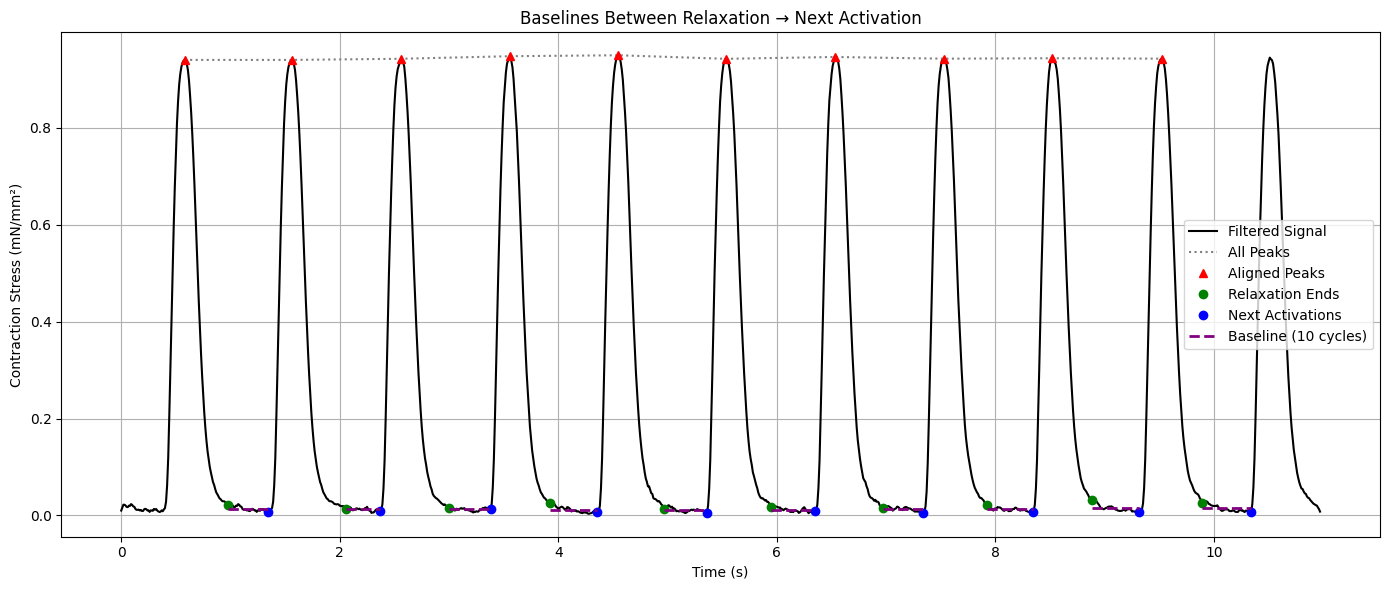

Error processing stress_1HZ_1_flood_fill.csv: [Errno 13] Permission denied: 'C:\\Users\\dorch\\OneDrive\\שולחן העבודה\\טכניון\\מעבדה כספי\\parametres of those graphs\\contraction analysis parameters of stress_1HZ_1_flood_fill.xlsx'
Processing: stress_1HZ_2_flood_fill.csv


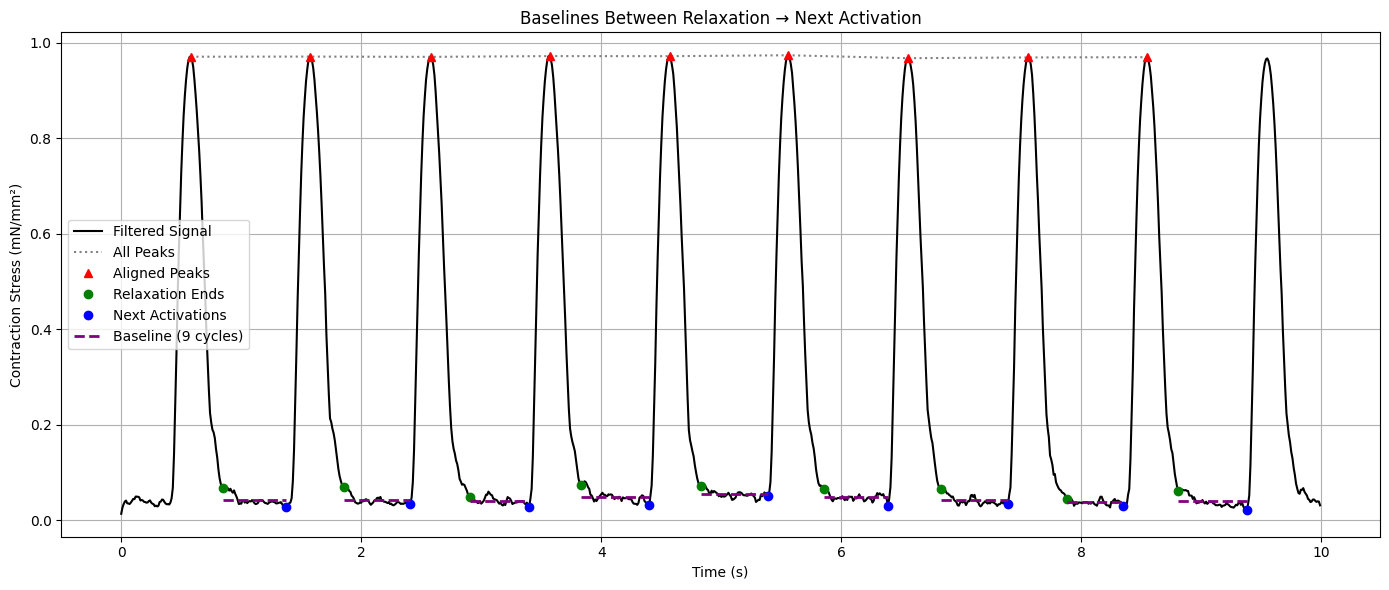

Excel with the parametes is prepered
Saved: C:\Users\dorch\OneDrive\שולחן העבודה\טכניון\מעבדה כספי\parametres of those graphs\contraction analysis parameters of stress_1HZ_2_flood_fill.xlsx
Processing: stress_1HZ_3_flood_fill.csv


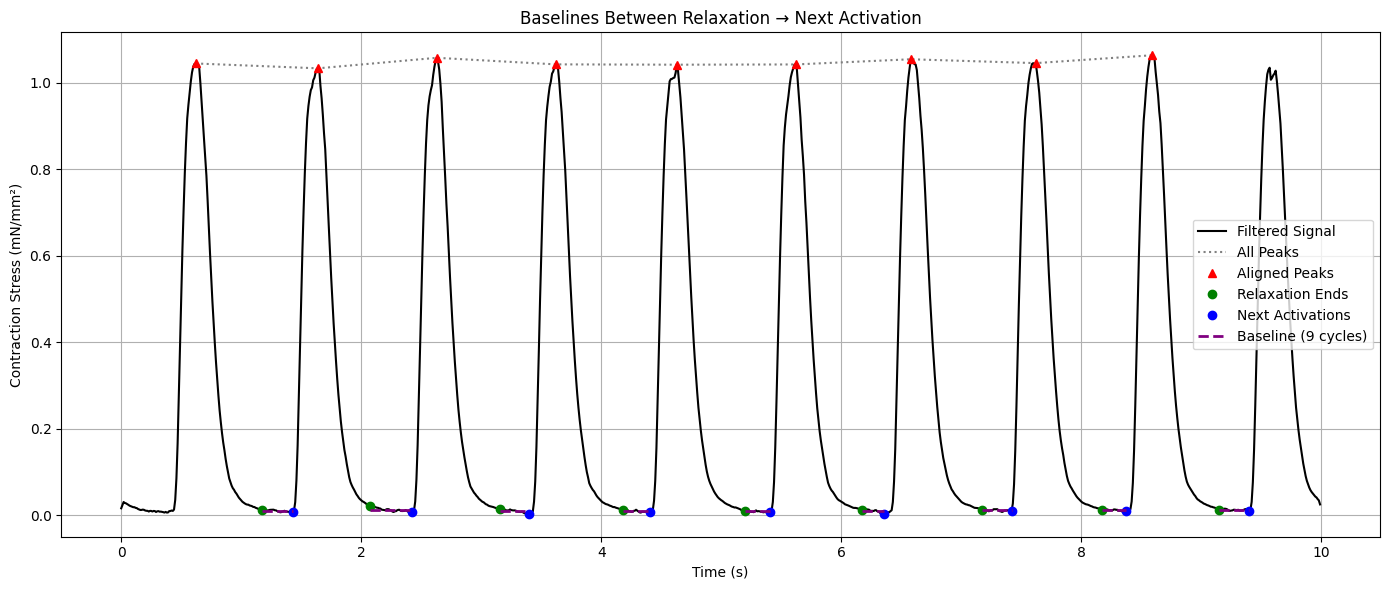

Excel with the parametes is prepered
Saved: C:\Users\dorch\OneDrive\שולחן העבודה\טכניון\מעבדה כספי\parametres of those graphs\contraction analysis parameters of stress_1HZ_3_flood_fill.xlsx
Processing: stress_2HZ_4_flood_fill.csv


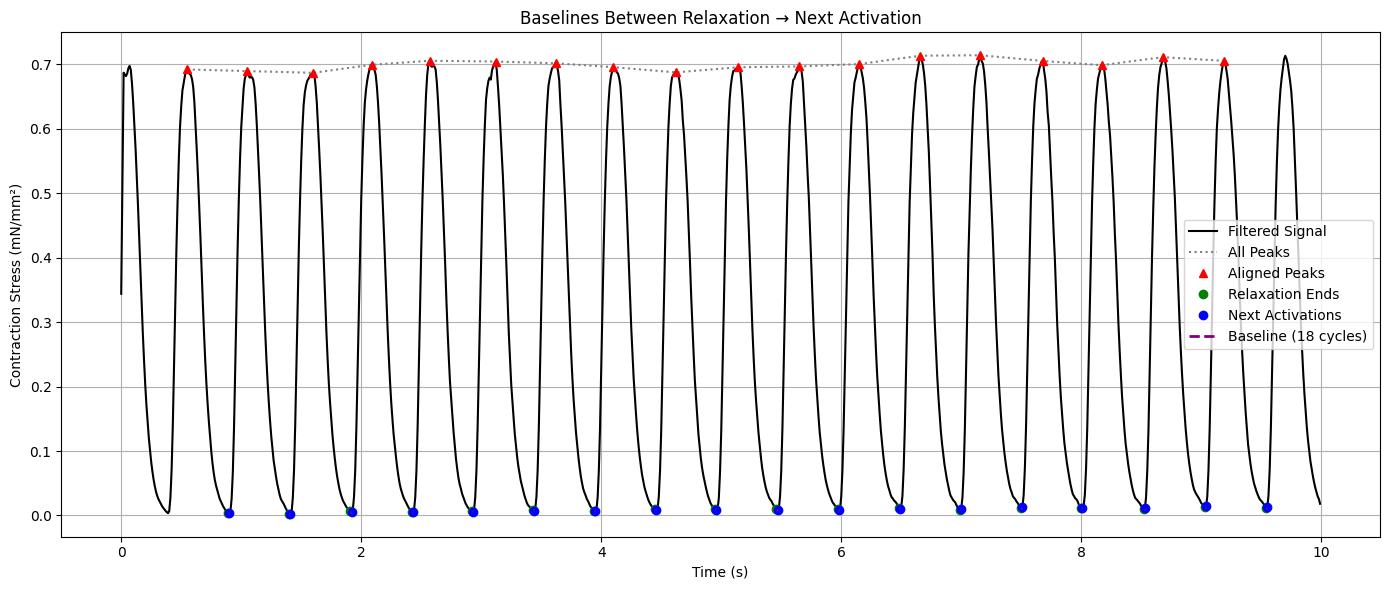

Excel with the parametes is prepered
Saved: C:\Users\dorch\OneDrive\שולחן העבודה\טכניון\מעבדה כספי\parametres of those graphs\contraction analysis parameters of stress_2HZ_4_flood_fill.xlsx


In [49]:
# Define folders
input_folder = r"C:\Users\dorch\OneDrive\שולחן העבודה\טכניון\מעבדה כספי\graphs of contracts"
output_folder = r"C:\Users\dorch\OneDrive\שולחן העבודה\טכניון\מעבדה כספי\parametres of those graphs"
os.makedirs(output_folder, exist_ok=True)

# Get list of all Excel files
excel_files = glob(os.path.join(input_folder, "*.csv"))

# Process each file
for file_path in excel_files:
    try:
        file_name = os.path.basename(file_path)
        base_name = os.path.splitext(file_name)[0]
        print(f"Processing: {file_name}")

        # === Load Data ===
        df = pd.read_csv(file_path)
        contraction_stress = df['stress_kpa']
        frame_time_point = df['frame']
        frame_rate_per_sec = 100
        frame_time_point_sec = frame_time_point / frame_rate_per_sec

        # === Preprocessing ===
        filtered_full = preprocess_full_moving_avg(contraction_stress, frame_time_point, window_size=4, display=False)

        # === Gradient & Peak Detection ===
        gradient_full = compute_signal_gradient(filtered_full, frame_time_point_sec, display=False)
        peaks, _ = find_peaks(filtered_full, prominence=0.1, distance=20)

        # === Detect relax & activation points ===
        end_relax_idxs = detect_contraction_relaxation_end_points(
            signal=filtered_full,
            time_vector=frame_time_point_sec,
            gradient_prominence=2,
            min_peak_distance=20,
            display=False
        )

        start_activation_idx = detect_contraction_rise_points(
            signal=filtered_full,
            time_vector=frame_time_point_sec,
            gradient_prominence=2,
            min_peak_distance=20,
            display=False
        )

        # print(f' peaks : {peaks}')
        # print(f' end_relax_idxs : {end_relax_idxs}')
        # print(f' start_activation_idx : {start_activation_idx}')

        # === Align peaks to valid contraction cycles ===
        aligned_acts, aligned_peaks, aligned_rels, aligned_next_acts = align_contraction_cycles_with_next_activation(
            peaks=peaks,
            start_activations=start_activation_idx,
            end_relaxations=end_relax_idxs)

        # === Create output Excel ===
        output_filename = os.path.join(output_folder, f"contraction analysis parameters of {base_name}.xlsx")
        df_cycles, df_summary = create_summary_excel_with_means(
            signal=filtered_full,
            time_vector=frame_time_point_sec,
            peaks=aligned_peaks,
            start_activation_idx=start_activation_idx,
            end_relax_idxs=end_relax_idxs,
            output_filename=output_filename
        )

        print(f"Saved: {output_filename}")

    except Exception as e:
        print(f"Error processing {file_name}: {e}")